<a href="https://colab.research.google.com/github/alexey9019/data/blob/master/Copy_of_sem_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с текстами

<h2> Проблема Классификации Токсичных Комментариев </h2>

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


Угроза злоупотреблений и преследований в интернете означает, что многие люди перестают выражать себя и откажутся от поиска различных мнений. Платформы изо всех сил пытаются эффективно облегчить разговоры, что приводит к тому, что многие сообщества ограничивают или полностью закрывают комментарии пользователей.

Команда Conversation AI основанная Jigsaw и Google (оба являются частью Alphabet) работает над инструментами, которые помогут улучшить онлайн-разговор. Одной из интересных областей является изучение негативного поведения в интернете, такое как токсичные комментарии (т. е. комментарии, которые являются грубыми, неуважительными или иным образом могут заставить кого-то покинуть дискуссию). До сих пор они создали ряд общедоступных моделей, обслуживаемых через перспективный API, включая токсичность. Но текущие модели все еще допускают ошибки и они не позволяют пользователям выбирать, какого типа токсичность они заинтересованы находить (например некоторые платформы могут одобрять ненормативную лексику, но не с другими типами токсичного контента).

Вам надо построить модель, которая способна обнаруживать различные типы токсичности, такие как угрозы, непристойноые выражения, оскорбления и ненависть на основе идентичности.



<h2> «Аффтар выпей йаду и пеши исчо» </h2> 

## Подгрузка данных

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import pyplot as plt

In [0]:
!git clone https://github.com/tixonsit/Sberbank_materials.git

Cloning into 'Sberbank_materials'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 36 (delta 1), reused 4 (delta 1), pack-reused 31
Unpacking objects: 100% (36/36), done.


In [0]:
# подгрузим датасет
train = pd.read_csv('/content/Sberbank_materials/train_toxic.csv')
test = pd.read_csv('/content/Sberbank_materials/test_toxic.csv')
# целевая переменная
target = train['toxic']

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Графический анализ

0.09584448302009764
Minimum accuracy: 0.9041555169799024


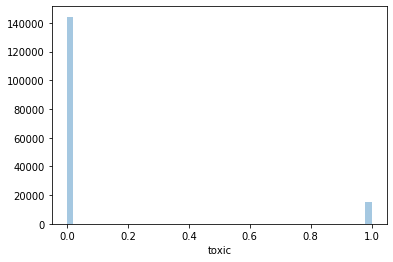

In [0]:
# посмотрим на сбалансированность классов
sns.distplot(target, kde=False)
print(target.mean())
print('Minimum accuracy:', max(target.mean(), 1 - target.mean()))

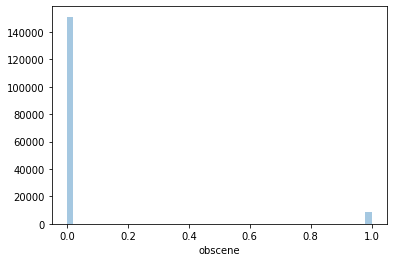

In [0]:
# посмотрим на сбалансированность классов
sns.distplot(train['obscene'], kde=False)

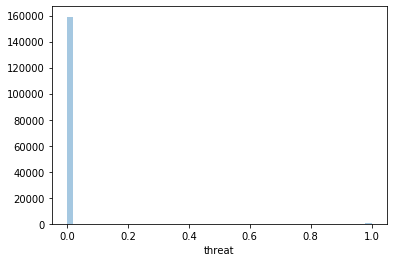

In [0]:
sns.distplot(train['threat'], kde=False)

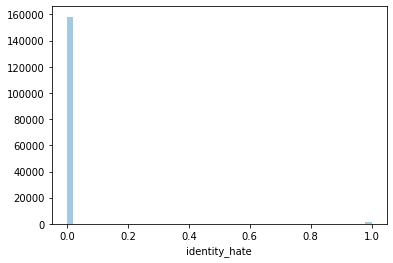

In [0]:
sns.distplot(train['identity_hate'], kde=False)

# Работа с признаками

## Предобработка

Для начала текст нужно предобработать, убрать пробелы, пунктуацию, прочее

In [0]:
import string

# фунция предобработки документа
def preprocess(doc):
    # понижение регистра
    doc = doc.lower()
    # убираем пунктуацию и пропуски (табуляция, пробелы, ... )
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # обрезаем все разделенные слова по краям (убираем пробелы, которые остались)
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

## TF-IDF

Сопоставляет вектор для каждого образца текста: text - > вектор $v$ из $R^N$, где $N$ - размер словаря.

$TF-IDF(token, document) = TF(token, document) * IDF(token, document)$

$TF$ это частота термина:

$TF(token, document) = \frac{n_{token}}{\sum_{k}n_k}.$

$IDF$ это обратная частота термина:

$IDF(token, all\_documents) = \frac{Total\ number\ of\ documents}{number\ of\ documents\ where\ token\ appeared}.$

применим поэлементно функцию ко всем словам в тексте

In [0]:
# Preprocessed text corpus
corpus = train['comment_text'].map(preprocess)
corpus.head(10)

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
5    congratulations from me as well use the tools ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense was offensive to yo...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)

X_tfidf = vectorizer.fit_transform(corpus)
print(X_tfidf.shape)

(159571, 10000)


In [0]:
type(X_tfidf)

scipy.sparse.csr.csr_matrix

In [0]:
X = X_tfidf.toarray()
X.shape

(159571, 10000)

In [0]:
type(X)

numpy.ndarray

# Алгоритмы

## Классические алгоритмы

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.utils.testing import ignore_warnings

In [0]:
def eval_on_trainset(X, y, model_names=None):
    # определяем модели и их параметры
    models = {
        'SVM_linear': SVC(C=100, kernel='linear'),
        'Log regression': LogisticRegression(),
        'naive bayes': GaussianNB(),
        'random forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
    }
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    print('Dummy accuracy:', max(y.mean(), 1 - y.mean()))
    print()
    # проходимся по выбранным моделям
    for name in model_names or sorted(models):
        # выбираем определенные в словаре параметры
        model = models[name]
        # проводим кросс-валидацию на 3 фолдах
        with ignore_warnings():
            scores_svc = cross_validate(model, X, y, cv=3, scoring=scoring)
        # отображаем результат
        for sc in scoring:
            mean = scores_svc['test_' + sc].mean()
            std = scores_svc['test_' + sc].std()
            print(name, sc, '{:.03} +- {:.03}'.format(mean, std))
        print()

In [0]:
print('X_shape:',X[:3000].shape)
print('y_shape:',target[:3000].values.shape)

X_shape: (3000, 10000)
y_shape: (3000,)


In [0]:
eval_on_trainset(X_tfidf[:3000], target[:3000].values, ['KNN', 'SVM_linear', 'random forest'])

Dummy accuracy: 0.8976666666666666

KNN accuracy 0.934 +- 0.00445
KNN precision 0.882 +- 0.0554
KNN recall 0.407 +- 0.0218
KNN f1 0.557 +- 0.0281
KNN roc_auc 0.841 +- 0.0234

SVM_linear accuracy 0.938 +- 0.00414
SVM_linear precision 0.848 +- 0.0129
SVM_linear recall 0.476 +- 0.0379
SVM_linear f1 0.609 +- 0.034
SVM_linear roc_auc 0.908 +- 0.00647

random forest accuracy 0.917 +- 0.00462
random forest precision 0.899 +- 0.0503
random forest recall 0.209 +- 0.0367
random forest f1 0.337 +- 0.051
random forest roc_auc 0.831 +- 0.017



## Нейросетевые подходы

### Полносвязная сеть

In [0]:
# импортируем библиотеки
# модули для быстрых операций с числами
import numpy as np
import pandas as pd
# модули для получения данных, работы с папками
import os
from operator import itemgetter
# модули для визуализации
import matplotlib.pyplot as plt
import warnings
# модули для создания сетей
import tensorflow as tf
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical

# игнорируем предупреждения
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

In [0]:
print(X.shape)
y = target.values
print(y.shape)

NameError: ignored

In [0]:
del X_tfidf

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
del X
del y

In [0]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (127656, 10000)
y_train: (127656,)
X_test: (31915, 10000)
y_test: (31915,)


In [0]:
model = models.Sequential()
model.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# FIT / TRAIN model
NumEpochs = 3
BatchSize = 256

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# сохраним историю метрик качества по эпохам
history = model.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(X_test, y_test))

results = model.evaluate(X_test, y_test)
print("_"*100)
print("Тестовый loss и accuracy", results)
# запишем результаты
history_dict = history.history
# history_dict.keys()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 127656 samples, validate on 31915 samples
Epoch 1/3





127656/127656 [==============================] - 30s 231us/step - loss: 3.7070 - acc: 0.9040 - val_loss: 2.5472 - val_acc: 0.9038
Epoch 2/3
127656/127656 [==============================] - 23s 182us/step - loss: 2.5400 - acc: 0.9042 - val_loss: 2.5332 - val_acc: 0.9038
Epoch 3/3
31915/31915 [==============================] - 2s 78us/step
____________________________________________________________________________________________________
Тестовый loss и accuracy [2.541709666287247, 0.9038383205389315]


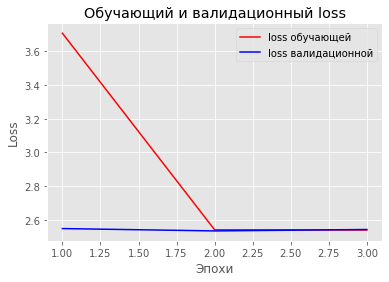

In [0]:
# посмотрим на графики изменения ошибки по эпохе
plt.clf()
history_dict = history.history
# получим значения из сохраненного словаря с историей
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'r', label='loss обучающей')
plt.plot(epochs, val_loss_values, 'b', label='loss валидационной')
plt.title('Обучающий и валидационный loss')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()

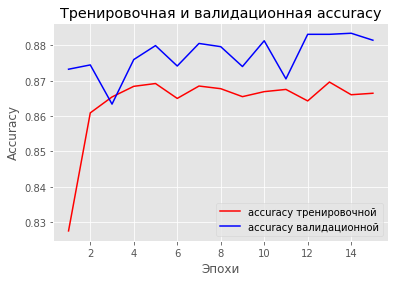

In [0]:
# accuracy на валидационной выборке
plt.clf()
# получим значения из сохраненного словаря с историей
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
# построим графики по accuracy на train и val
plt.plot(epochs, acc_values, 'r', label='accuracy тренировочной')
plt.plot(epochs, val_acc_values, 'b', label='accuracy валидационной')
plt.title('Тренировочная и валидационная accuracy')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import classification_report

# получим от нее предсказания по модели
predictions = model.predict(X_test)
print('Сырой вид наших предсказаний')
# округлим предсказания в сторону 0 или 1, сравнив с тестовой
print(classification_report(y_test, np.around(predictions)))

Сырой вид наших предсказаний
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     28846
           1       0.00      0.00      0.00      3069

    accuracy                           0.90     31915
   macro avg       0.45      0.50      0.47     31915
weighted avg       0.82      0.90      0.86     31915



#### Балансируем выборку

Найдем id токсичных комментариев

In [0]:
tox_ids = np.argwhere(target.values == 1)
tox_ids

array([[     6],
       [    12],
       [    16],
       ...,
       [159541],
       [159546],
       [159554]])

Приводим к виду, которым можно индексировать

In [0]:
tox_ids = tox_ids.T[0]
tox_ids

array([     6,     12,     16, ..., 159541, 159546, 159554])

In [0]:
len(tox_ids)

15294

Найдем id обычных комментариев

In [0]:
not_tox_ids = np.argwhere(target.values == 0)
not_tox_ids

array([[     0],
       [     1],
       [     2],
       ...,
       [159568],
       [159569],
       [159570]])

Приводим к виду, которым можно индексировать

In [0]:
not_tox_ids = not_tox_ids.T[0]
not_tox_ids

array([     0,      1,      2, ..., 159568, 159569, 159570])

In [0]:
len(not_tox_ids)

144277

Перемешаем не токсичные id

In [0]:
from sklearn.utils import shuffle

not_tox_ids = shuffle(not_tox_ids)
not_tox_ids

array([49869, 33931, 94098, ..., 50823, 49721, 16626])

Обрежем их до кол-ва нетоксичных

In [0]:
not_tox_ids = not_tox_ids[:len(tox_ids)]
not_tox_ids

array([49869, 33931, 94098, ..., 99770,  7531, 79549])

In [0]:
len(not_tox_ids)

15294

In [0]:
len(tox_ids)

15294

Cоздадим новую, сбалансированную обучающую выборку

In [0]:
balanced_ids = np.append(not_tox_ids, tox_ids)
balanced_ids

array([ 49869,  33931,  94098, ..., 159541, 159546, 159554])

In [0]:
len(balanced_ids)

30588

In [0]:
balanced_ids = shuffle(balanced_ids)
balanced_ids

array([ 3750, 68569, 77104, ..., 29790, 55264, 43994])

Освободим память от старых, несбалансированных данных

In [0]:
del X_train, y_train

In [0]:
del X_test, y_test

Опять получим tfidf представления

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)

X_tfidf = vectorizer.fit_transform(corpus)
print(X_tfidf.shape)
X = X_tfidf.toarray()
X.shape

(159571, 10000)


(159571, 10000)

Сбалансируем

In [0]:
X_bal = X[balanced_ids]
X_bal.shape

(30588, 10000)

In [0]:
y_bal = target.values[balanced_ids]
y_bal.shape

(30588,)

Получили новую сбалансированную выборку

In [0]:
X_bal

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
y_bal

array([0, 0, 0, ..., 1, 1, 0])

In [0]:
# чистим память
del X

### Сбалансированная полносвязаня сеть

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2)

In [0]:
X_train = X_bal[:24000]
y_train = y_bal[:24000]

X_test = X_bal[24000:]
y_test = y_bal[24000:]

In [0]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (24000, 10000)
y_train: (24000,)
X_test: (6588, 10000)
y_test: (6588,)


In [0]:
model = models.Sequential()
model.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation='tanh'))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='tanh'))

In [0]:
# FIT / TRAIN model
NumEpochs = 15
BatchSize = 32

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# сохраним историю метрик качества по эпохам
history = model.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(X_test, y_test))

results = model.evaluate(X_test, y_test)
print("_"*100)
print("Тестовый loss и accuracy", results)
# запишем результаты
history_dict = history.history
# history_dict.keys()

Train on 24000 samples, validate on 6588 samples
Epoch 1/15
24000/24000 [==============================] - 6s 236us/step - loss: 3.8706 - acc: 0.8275 - val_loss: 2.7154 - val_acc: 0.8733
Epoch 2/15
24000/24000 [==============================] - 5s 212us/step - loss: 2.6889 - acc: 0.8609 - val_loss: 2.6588 - val_acc: 0.8745
Epoch 3/15
24000/24000 [==============================] - 5s 213us/step - loss: 2.6509 - acc: 0.8654 - val_loss: 2.6608 - val_acc: 0.8634
Epoch 4/15
24000/24000 [==============================] - 5s 212us/step - loss: 2.6310 - acc: 0.8684 - val_loss: 2.6069 - val_acc: 0.8760
Epoch 5/15
24000/24000 [==============================] - 5s 212us/step - loss: 2.6195 - acc: 0.8692 - val_loss: 2.5973 - val_acc: 0.8799
Epoch 6/15
24000/24000 [==============================] - 5s 215us/step - loss: 2.6158 - acc: 0.8650 - val_loss: 2.5975 - val_acc: 0.8742
Epoch 7/15
24000/24000 [==============================] - 5s 215us/step - loss: 2.6093 - acc: 0.8685 - val_loss: 2.5875 - v

In [0]:
from sklearn.metrics import classification_report

# получим от нее предсказания по модели
predictions = model.predict(X_test)
print('Сырой вид наших предсказаний')
# округлим предсказания в сторону 0 или 1, сравнив с тестовой
print(classification_report(y_test, np.around(predictions)))

Сырой вид наших предсказаний
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      3317
           1       0.91      0.85      0.88      3271

    accuracy                           0.88      6588
   macro avg       0.88      0.88      0.88      6588
weighted avg       0.88      0.88      0.88      6588



In [0]:
model.predict(X_test)[:30]

array([[0.8769071 ],
       [0.05328475],
       [0.10152989],
       [0.9956951 ],
       [0.05328475],
       [0.05635669],
       [0.05328475],
       [0.99987817],
       [0.67906404],
       [0.80673105],
       [0.05328475],
       [0.05328475],
       [0.7925978 ],
       [0.9494544 ],
       [0.40488014],
       [0.99980915],
       [0.20673175],
       [0.3891463 ],
       [0.3694962 ],
       [0.05328475],
       [0.9971804 ],
       [0.9464128 ],
       [0.05328475],
       [0.05328475],
       [0.83875513],
       [0.9998146 ],
       [0.5240232 ],
       [0.6872589 ],
       [0.99948084],
       [0.5567975 ]], dtype=float32)

In [0]:
for i, text in enumerate(corpus[balanced_ids[24000:]][:20]):
    print('label', target.values[balanced_ids[24000:]][i])
    # print('prediction', model.predict(np.array([X_test[i]])))
    print(text)
    print()

label 1
you know what im not listening to you good bye keep threating me punk stay black

label 1
wikipedia appears to work on the basis that a collective can enforce reality on an individual and i have the mainstream media if i want to be that bullshitted

label 0
epithelium all of that can be found in any introductory anatomy text an article on epthelia is pretty useless without mentioning stratified epithelia

label 1
u dam stupid son of a why u want trouble wij the polece kew

label 0
tony hi and thank you for your message clearly im new at this so thank you so much for your suggestion ill try to move to the talk page i m not clear if you work for wikipedia but in case you do just a suggestion from a novice it d be great if they made wikipedia more user friendly to edit it currently looks like a piece of matrix code to try and edit it i dont even know how we are talking there wasnt even a reply button to your message thanks for bearing with me

label 0
good for you give yourself a 

### LSTM

In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [0]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
# Реализуем многоклассовую классификацию
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [0]:
list_sentences_train[6]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [0]:
y[6]

array([1, 1, 1, 0, 1, 0])

In [0]:
# токенизируем слова
max_features = 50000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [0]:
maxlen = 350
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

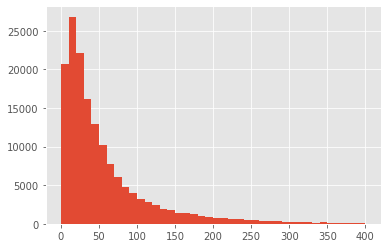

In [0]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

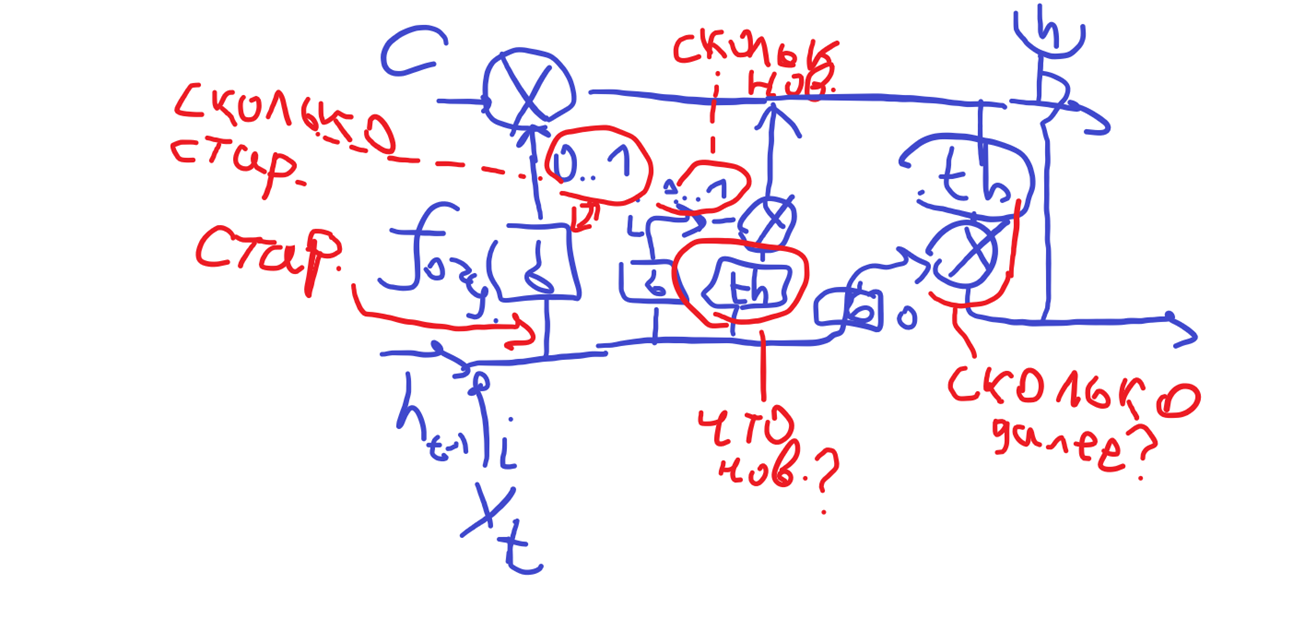

In [0]:
embed_size = 248

inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNLSTM(248, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [0]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
batch_size = 32
epochs = 5

model.fit(X_t,
          y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 155s 1ms/step - loss: 0.0647 - acc: 0.9785 - val_loss: 0.0481 - val_acc: 0.9820
Epoch 2/5
143613/143613 [==============================] - 154s 1ms/step - loss: 0.0433 - acc: 0.9836 - val_loss: 0.0470 - val_acc: 0.9824
Epoch 3/5
143613/143613 [==============================] - 154s 1ms/step - loss: 0.0372 - acc: 0.9854 - val_loss: 0.0468 - val_acc: 0.9826
Epoch 4/5
143613/143613 [==============================] - 154s 1ms/step - loss: 0.0324 - acc: 0.9871 - val_loss: 0.0494 - val_acc: 0.9824
Epoch 5/5
143613/143613 [==============================] - 154s 1ms/step - loss: 0.0287 - acc: 0.9886 - val_loss: 0.0541 - val_acc: 0.9815


#### Пример распознавания на новой фразе

[0.97894657 0.24531361 0.7393558  0.2493799  0.82921404 0.30987316]


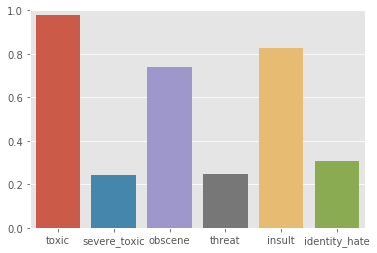

In [0]:
# фраза, которую хотим распознать
test_phrase = 'i will kill you idiot'
# токенизированная слова, которых не будет заменятся на 1
tokenized_phraze = tokenizer.texts_to_sequences([test_phrase])

# обрезка под нужный формат (у нас 250 слов) - не хватает - заолняем нулями
# слишкоим много - обрезаем
padded_tokenized = pad_sequences(tokenized_phraze, maxlen=maxlen)

# фиксируем ось y, по которой происходит предсказание (0..1)
plt.ylim(0., 1.)
# строим по y предсказания от сети (следите за форматом ввода)
# по х - названия распознаваемых классов
print(model.predict(np.array(padded_tokenized) )[0])
ax = sns.barplot(x=list_classes, y=model.predict(np.array(padded_tokenized) )[0])

In [0]:
model.predict(np.array(padded_tokenized) )[0]

array([0.10677031, 0.00041741, 0.00435936, 0.01660571, 0.00601083,
       0.11164365], dtype=float32)

In [0]:
result = model.predict(X_te)

In [0]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

. 

           Jews are not a race because you can only get it from your mother. Your own mention of Ethiopian Jews not testing 
           as Jews proves it is not, as well as the fact that we accept converts


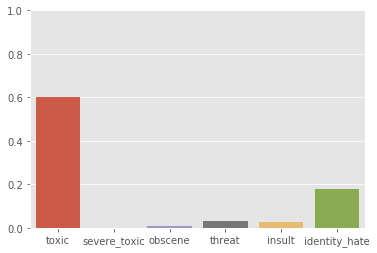

In [0]:
id_ = 28

plt.ylim(0., 1.)
ax = sns.barplot(x=list_classes, y=result[id_])

print(list_sentences_test[id_])

In [0]:
for i, sent in enumerate(list_sentences_test[:5]):
    print('comment', i)
    print(list_classes)
    print('prediction', result[i])
    print(sent)
    print('')

comment 0
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
prediction [0.99841636 0.37327173 0.9722822  0.25592566 0.9218691  0.44353905]
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,

comment 1
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
prediction [1.1205673e-05 0.0000000e+00 9.5367432e-07 0.0000000e+00 2.3841858e-07
 8.9406967e-08]
== From RfC == 

 The title is fine as it is, IMO.

comment 2
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
prediction [1.9710362e-03 0.0000000e+00 2.3293495e-04 5.8710575e-06 8.9585781e-05
 1.6689301e-05]
" 

 == Sources == 

 * Zawe Ashton on Lapland —  / 

In [0]:
for res in result[:30]:
    print(res)

[0.99841636 0.37327173 0.9722822  0.25592566 0.9218691  0.44353905]
[1.1205673e-05 0.0000000e+00 9.5367432e-07 0.0000000e+00 2.3841858e-07
 8.9406967e-08]
[1.9710362e-03 0.0000000e+00 2.3293495e-04 5.8710575e-06 8.9585781e-05
 1.6689301e-05]
[1.5854836e-05 0.0000000e+00 2.5033951e-06 2.9802322e-08 4.1723251e-07
 1.7881393e-07]
[8.586943e-04 0.000000e+00 8.252263e-05 8.046627e-07 5.155802e-06
 2.503395e-06]
[8.8483095e-05 0.0000000e+00 1.6272068e-05 2.9802322e-07 5.3942204e-06
 1.4901161e-06]
[6.3776970e-06 0.0000000e+00 1.2516975e-06 2.9802322e-08 1.1920929e-07
 2.9802322e-07]
[8.47399056e-01 8.06182623e-04 7.63794780e-02 1.83045864e-03
 1.15435064e-01 3.23724747e-03]
[3.7553906e-04 0.0000000e+00 3.4034252e-05 1.1920929e-07 4.1723251e-06
 4.1723251e-06]
[3.0398369e-06 0.0000000e+00 2.3841858e-07 0.0000000e+00 0.0000000e+00
 5.9604645e-08]
[8.3078814e-01 1.8889904e-03 3.4474212e-01 6.4095855e-04 1.3944894e-02
 8.8679790e-04]
[9.0846419e-04 0.0000000e+00 3.7911534e-04 1.4901161e-07 2.384

In [0]:
from sklearn.metrics import classification_report

# получим от нее предсказания по модели
predictions = model.predict(X_te)
print('Сырой вид наших предсказаний')
# округлим предсказания в сторону 0 или 1, сравнив с тестовой
print(classification_report(y_test, np.around(predictions)))

Сырой вид наших предсказаний


In [0]:
predictions

array([[9.9841636e-01, 3.7327173e-01, 9.7228217e-01, 2.5592566e-01,
        9.2186910e-01, 4.4353905e-01],
       [1.1205673e-05, 0.0000000e+00, 9.5367432e-07, 0.0000000e+00,
        2.3841858e-07, 8.9406967e-08],
       [1.9710362e-03, 0.0000000e+00, 2.3293495e-04, 5.8710575e-06,
        8.9585781e-05, 1.6689301e-05],
       ...,
       [3.9041042e-06, 0.0000000e+00, 1.7881393e-07, 0.0000000e+00,
        0.0000000e+00, 8.9406967e-08],
       [1.9073486e-06, 0.0000000e+00, 1.1920929e-07, 0.0000000e+00,
        0.0000000e+00, 3.2782555e-07],
       [9.7782534e-01, 3.2404155e-02, 8.1772208e-01, 3.6383271e-03,
        4.0059036e-01, 1.1279792e-02]], dtype=float32)

In [0]:
print(classification_report(y_test, np.around(predictions)))

ValueError: ignored